In [1]:
nb_bench = 3
col_name = ["func", "start", "end", "filename", "worker", "thread", "process"]

In [2]:
def wasted_time(filename, *, framework, func_map):
    df = pd.read_csv(filename, header=None, names=col_name)
    
    # Rename functions
    df.func = df.func.apply(lambda x: func_map[x])

    if framework == "spark":
        df["thread"] = df["process"]

    core_used = sum(
        [
            1
            for w in df.worker.unique()
            for i, t in enumerate(df[df.worker == w].thread.unique())
        ]
    )

    df["runtime"] = df.end - df.start
    func_time = df.groupby("func")["runtime"].sum()
    read_time = func_time["Read"]
    processing_time = func_time["Compute"]
    write_time = func_time["Write"]

    total_time = df.end.max() * core_used

    wasted_time = total_time - (read_time + processing_time + write_time)
    return read_time, processing_time, write_time, wasted_time

In [3]:
def idle_time(filename, *, framework, func_map):
    df = pd.read_csv(filename, header=None, names=col_name)
    
    # Rename functions
    df.func = df.func.apply(lambda x: func_map[x])
    
    if framework == "spark":
        df["thread"] = df["process"]

    by_thread = df.groupby(["worker", "thread"])

    df["runtime"] = df.end - df.start
    func_time = df.groupby("func")["runtime"].sum()
    read_time = func_time["Read"]
    processing_time = func_time["Compute"]
    write_time = func_time["Write"]

    thread_runtimes = by_thread["runtime"].sum()
    thread_completion = by_thread["end"].max()

    idle_time = (thread_completion - thread_runtimes).sum()
    return read_time, processing_time, write_time, idle_time

In [4]:
from math import sqrt
import os

import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd


def plot_timeline(exp_type, exp_names, xlabel, xticks_label, func, func_map, *, f_out=None):
    ## Path to result file
    spark_file_np = "../{0}/data/results-spark_{0}-{2}-{1}.csv"
    dask_bag_file_np = "../{0}/data/results-dask-bag_{0}-{2}-{1}.csv"
    dask_delayed_file_np = "../{0}/data/results-dask-delayed_{0}-{2}-{1}.csv"

    # Retrieve file name
    spark_np = [
        [
            func(spark_file_np.format(exp_type, nth_bench, exp_name),
                 framework="spark",
                 func_map=func_map)
            for nth_bench in range(1, nb_bench + 1)
            if os.path.exists(spark_file_np.format(exp_type, nth_bench, exp_name))
        ]
        for exp_name in exp_names
    ]

    dask_bag_np = [
        [
            func(dask_bag_file_np.format(exp_type, nth_bench, exp_name),
                 framework="dask",
                 func_map=func_map)
            for nth_bench in range(1, nb_bench + 1)
            if os.path.exists(dask_bag_file_np.format(exp_type, nth_bench, exp_name))
        ]
        for exp_name in exp_names
    ]
    
    dask_delayed_np = [
        [
            func(dask_delayed_file_np.format(exp_type, nth_bench, exp_name),
                 framework="dask",
                 func_map=func_map)
            for nth_bench in range(1, nb_bench + 1)
            if os.path.exists(dask_delayed_file_np.format(exp_type, nth_bench, exp_name))
        ]
        for exp_name in exp_names
    ]

    def get_stat(data):
        data = [[(0, 0, 0, 0)] * 5 if x == [] else x for x in data]
        rv = []
        for i in range(len(data)):
            packed = list(zip(*data[i]))

            stats = list(zip(map(np.mean, zip(*data[i])), map(np.std, zip(*data[i]))))
            rv.append(stats)
        arr = [*zip(*rv)]

        for i in range(len(arr)):
            tmp = [*zip(*arr[i])]
            arr[i] = {"mean": np.array(tmp[0]), "std": np.array(tmp[1])}
        return arr

    # Calculate statistics
    spark_np_stat = get_stat(spark_np)
    dask_bag_np_stat = get_stat(dask_bag_np)
    dask_delayed_np_stat = get_stat(dask_delayed_np)

    # Generate plot
    fig, ax = plt.subplots(figsize=(10, 5))

    barWidth = 0.15

    # Set position of bar on X axis
    r1 = np.arange(len(spark_np))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    read = plt.bar(
        r1,
        spark_np_stat[0]["mean"],
        yerr=spark_np_stat[0]["std"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="\\\\",
    )
    increment = plt.bar(
        r1,
        spark_np_stat[1]["mean"],
        yerr=spark_np_stat[1]["std"],
        bottom=spark_np_stat[0]["mean"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        label="Spark - NumPy",
    )
    save = plt.bar(
        r1,
        spark_np_stat[2]["mean"],
        yerr=spark_np_stat[2]["std"],
        bottom=spark_np_stat[1]["mean"] + spark_np_stat[0]["mean"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="xxx",
    )
    idle = plt.bar(
        r1,
        spark_np_stat[3]["mean"],
        yerr=spark_np_stat[3]["std"],
        bottom=spark_np_stat[2]["mean"] + spark_np_stat[1]["mean"] + spark_np_stat[0]["mean"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="ooo",
    )

    plt.bar(
        r2,
        dask_bag_np_stat[0]["mean"],
        yerr=dask_bag_np_stat[0]["std"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="\\\\",
    )
    plt.bar(
        r2,
        dask_bag_np_stat[1]["mean"],
        yerr=dask_bag_np_stat[1]["std"],
        bottom=dask_bag_np_stat[0]["mean"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        label="Dask Bag - NumPy",
    )
    plt.bar(
        r2,
        dask_bag_np_stat[2]["mean"],
        yerr=dask_bag_np_stat[2]["std"],
        bottom=dask_bag_np_stat[1]["mean"] + dask_bag_np_stat[0]["mean"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="xxx",
    )
    plt.bar(
        r2,
        dask_bag_np_stat[3]["mean"],
        yerr=dask_bag_np_stat[3]["std"],
        bottom=dask_bag_np_stat[2]["mean"]
        + dask_bag_np_stat[1]["mean"]
        + dask_bag_np_stat[0]["mean"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="ooo",
    )
    
    plt.bar(
        r3,
        dask_delayed_np_stat[0]["mean"],
        yerr=dask_delayed_np_stat[0]["std"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="\\\\",
    )
    plt.bar(
        r3,
        dask_delayed_np_stat[1]["mean"],
        yerr=dask_delayed_np_stat[1]["std"],
        bottom=dask_delayed_np_stat[0]["mean"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        label="Dask Delayed - Numpy",
    )
    plt.bar(
        r3,
        dask_delayed_np_stat[2]["mean"],
        yerr=dask_delayed_np_stat[2]["std"],
        bottom=dask_delayed_np_stat[1]["mean"] + dask_delayed_np_stat[0]["mean"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="xxx",
    )
    plt.bar(
        r3,
        dask_delayed_np_stat[3]["mean"],
        yerr=dask_delayed_np_stat[3]["std"],
        bottom=dask_delayed_np_stat[2]["mean"]
        + dask_delayed_np_stat[1]["mean"]
        + dask_delayed_np_stat[0]["mean"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="ooo",
    )

    # Add xticks on the middle of the group bars
    plt.xlabel(xlabel, fontweight="bold")
    plt.xticks([r + barWidth for r in r1], xticks_label)
    plt.ylabel("Total time [s]")
    plt.ylim([0,50000])

    # Framework legend
    leg1 = plt.legend(loc="upper right", bbox_to_anchor=(1.285, 1.02))

    # Function legend
    read_patch = Patch(
        facecolor="gray", edgecolor="black", hatch="\\\\\\", label="Read"
    )
    increment_patch = Patch(facecolor="gray", edgecolor="black", label="Compute")
    save_patch = Patch(facecolor="gray", edgecolor="black", hatch="xxx", label="Write")
    idle_patch = Patch(
        facecolor="gray", edgecolor="black", hatch="ooo", label="Overhead"
    )
    leg2 = plt.legend(
        loc="upper right",
        handles=[read_patch, increment_patch, save_patch, idle_patch],
        bbox_to_anchor=(1.17, 0.825),
    )
    ax.add_artist(leg1)
    
    if f_out:
        plt.savefig("./figures/"+f_out, bbox_inches='tight')
        
        
    plt.show()

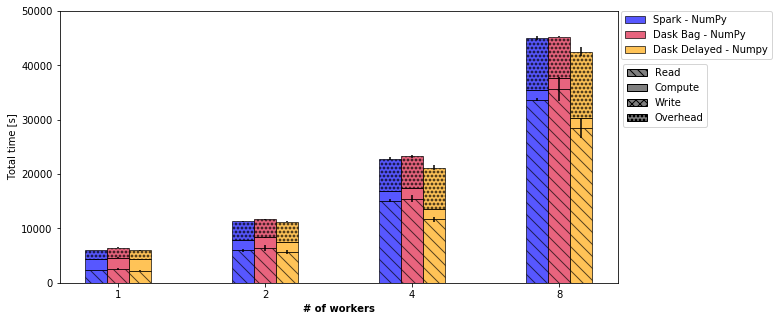

In [5]:
exp_type = "histogram"
exp_names = ["1node", "2node", "4node", "baseline"]
xlabel = "# of workers"
xticks_label = ["1", "2", "4", "8"]
func = idle_time
func_map = {
    'read_img': 'Read',
    'save_histogram': 'Write',
    "flatten": "Compute",
    'calculate_histogram': 'Compute',
    'combine_histogram': 'Compute',
    'find_frequency': 'Compute'
}
f_out = "histo_idle_np_worker.png"


plot_timeline(exp_type,
              exp_names,
              xlabel,
              xticks_label,
              func,
              func_map,
              f_out=f_out)

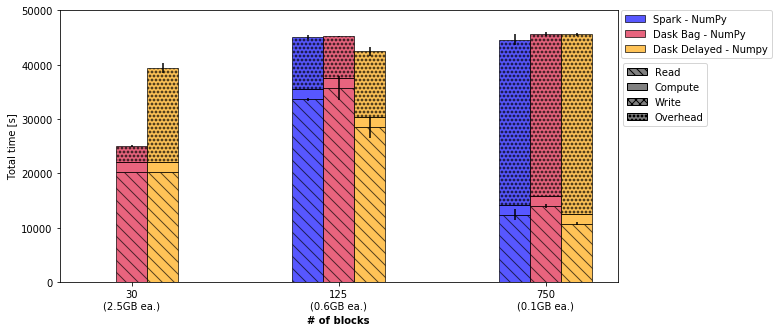

In [6]:
exp_type = "histogram"
exp_names = ["30chunks", "baseline", "750chunks"]
xlabel = "# of blocks"
xticks_label = ["30\n(2.5GB ea.)", "125\n(0.6GB ea.)", "750\n(0.1GB ea.)"]
func = idle_time
func_map = {
    'read_img': 'Read',
    'save_histogram': 'Write',
    "flatten": "Compute",
    'calculate_histogram': 'Compute',
    'combine_histogram': 'Compute',
    'find_frequency': 'Compute'
}
f_out = "histo_idle_np_block.png"

plot_timeline(exp_type,
              exp_names,
              xlabel,
              xticks_label,
              func,
              func_map,
              f_out=f_out,)